# Transfer Learning

## Import Packages

In [1]:
# !pip uninstall ml_project_util -y
# !pip install git+https://github.com/aris-gk3/ml_project_util.git
# or for local development:
# %pip uninstall ml_project_util -y
%pip install git+https://github.com/aris-gk3/ml_project_util.git

import tensorflow as tf
import os
from tensorflow.keras import layers, models # type: ignore
from tensorflow.keras.applications import VGG16 # type: ignore
# Local Packages
from ml_project_util.path import path_definition
from ml_project_util.train import train, freeze_layers, unfreeze_head, unfreeze_block
from ml_project_util.quantization_util import quant_model, quant_bw_search
from ml_project_util.model_evaluation import model_evaluation_precise

  Cloning https://github.com/aris-gk3/ml_project_util.git to /tmp/pip-req-build-hipkrf90
  Running command git clone --filter=blob:none --quiet https://github.com/aris-gk3/ml_project_util.git /tmp/pip-req-build-hipkrf90
  Resolved https://github.com/aris-gk3/ml_project_util.git to commit 82d061a2b9b2f8c65f24c8244384153fc895ca61
  Preparing metadata (setup.py) ... done
  Created wheel for ml_project_util: filename=ml_project_util-0.1-py3-none-any.whl size=23769 sha256=8ff3549f0b1926356fa8dfc97201afe116f3fe3294462395f379880d69f2ef76
  Stored in directory: /tmp/pip-ephem-wheel-cache-t8fwg8y8/wheels/9b/33/7a/e8e8f55a4c6aa39df26369c48b9e3497c6dde4c7663912f8ef
Successfully built ml_project_util
Note: you may need to restart the kernel to use updated packages.


2025-06-23 10:46:52.320063: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750675612.530837      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750675612.591837      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Define Variable Paths

In [2]:
dict = path_definition(ds_rel_path='oxdord-pets-restructured') # path_definition.config to read
BASE_PATH = dict['BASE_PATH']
PATH_DATASET = dict['PATH_DATASET']
PATH_TEST = dict['PATH_TEST']
PATH_RAWDATA = dict['PATH_RAWDATA']
PATH_JOINEDDATA = dict['PATH_JOINEDDATA']
PATH_SAVEDMODELS = dict['PATH_SAVEDMODELS']

ds_rel_path set to: oxdord-pets-restructured


## Load Model for PTQ & Evaluation

In [3]:
model_name = 'OP1_P3_FT2_009_val0.4430'
parent_name = model_name[:3]
model_path = '/kaggle/input/op1_p3_ft/keras/default/1/OP1_P3_FT2_009_val0.4430.keras'
# model_path = f"{PATH_SAVEDMODELS}/{parent_name}/{model_name}.keras"
model = tf.keras.models.load_model(model_path)

I0000 00:00:1750675627.890518      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750675627.891219      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [4]:
# model_evaluation_precise(model, mode='val')
model_evaluation_precise(model, mode='test')

Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 0

I0000 00:00:1750675631.408572      19 cuda_dnn.cc:529] Loaded cuDNN version 90300
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.89946
Precise test loss: 0.30393


(0.8994565, 0.3039290709016116)

Quantizing model to 7 bits...
Saved json in: /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
Saved activation ranges in /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Saved json in: /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.05163
Precise test loss: 3.65936
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1494.113945603282


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 5009.800657248568


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14345.680003826108


For layer 4.
Next input range: {'min': 0.0, 'max'

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.02853
Precise test loss: 4.23472
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.868209623291428


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.48913093369380356


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.43326620557437834


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.39418932428565173


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6806834367808285


For layer 6.
Weight range: 0.4593163430690765

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.05299
Precise test loss: 4.17341
Quantizing model to 8 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.57337
Precise test loss: 1.41115
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'8b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1482.3492688662482


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4970.353407978894


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14232.72189355976


For lay

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.13451
Precise test loss: 3.65635
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'8b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.875100175857233


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.493012925231056


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.43670482625354007


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.3973178109863315


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6860856862790891


For la

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.61413
Precise test loss: 1.24124
Quantizing model to 9 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.84918
Precise test loss: 0.50088
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'9b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1476.5361344785374


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4950.86182598682


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14176.90729789874


For laye

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.72418
Precise test loss: 0.87537
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'9b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8785454521401355


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4949539209996822


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.43842413659312096


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.3988820543366714


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6887868110282194


For 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.84647
Precise test loss: 0.50042
Quantizing model to 10 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86005
Precise test loss: 0.42887
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'10b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1473.6466312799494


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4941.173250984889


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14149.163839390134


For l

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85054
Precise test loss: 0.46451
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'10b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8802680902815867


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4959244188839953


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4392837917629114


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.39966417601184134


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6901373734027845


For

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85734
Precise test loss: 0.44309
Quantizing model to 11 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86141
Precise test loss: 0.43343
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'11b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1472.2061164888644


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4936.343169605627


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14135.332789693759


For l

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86413
Precise test loss: 0.44351
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'11b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8811294093523123


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.49640966782615187


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4397136193478066


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.4000552368494263


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.690812654590067


For 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85870
Precise test loss: 0.43884
Quantizing model to 12 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86005
Precise test loss: 0.44418
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'12b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1471.486914673286


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4933.931668301472


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14128.42739995771


For lay

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86141
Precise test loss: 0.44124
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'12b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8815600688876751


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4966522922972301


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4399285331402542


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.4002507672682188


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6911502951837083


For 

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.86005
Precise test loss: 0.44369
Quantizing model to 13 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85870
Precise test loss: 0.44414
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'13b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1471.1275772093854


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4932.726800983205


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14124.977234536474


For l

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85598
Precise test loss: 0.44532
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'13b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8817753986553566


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.49677360453276925


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.44003599003647803


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.40034853247761504


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6913191154805289


F

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85598
Precise test loss: 0.44425
Quantizing model to 14 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44474
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'14b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1470.9479742821225


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4932.124587968801


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14123.25278364714


For la

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85598
Precise test loss: 0.44479
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'14b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8818830635391973


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4968342606505388


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4400897184845899


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.40039741508231314


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6914035256289393


For

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85598
Precise test loss: 0.44343
Quantizing model to 15 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44468
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'15b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1470.858189262634


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4931.823536599213


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14122.390716090304


For la

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85598
Precise test loss: 0.44499
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'15b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8819368959811176


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4968645887094236


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.44011658270864584


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.4004218563846622


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6914457307031444


For

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44427
Quantizing model to 16 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44445
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'16b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1470.813300863047


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4931.673024695877


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14121.959721775413


For la

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44465
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'16b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8819638122020778


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.496879752738866


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4401300148206738


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.4004340770358367


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.691466833240247


For la

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44475
Quantizing model to 17 bits...
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Quantization on arbitrary symmetric ranges is applied.
Read sw activation quantization range from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json.
New model input shape: (None, 224, 224, 3)
Found 736 files belonging to 37 classes.
Start evaluating batches
Batch Number: 1

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44486
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
'17b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


Read input range json from /kaggle/working/Docs_Reports/Quant/Ranges/input_range.json
For layer 1.
Next input range: {'min': 0.0, 'max': 1065.875244140625}
HW next input range: 1470.7908576906832


For layer 2.
Next input range: {'min': 0.0, 'max': 4237.02392578125}
HW next input range: 4931.597772189206


For layer 3.
Next input range: {'min': 0.0, 'max': 7459.59326171875}
HW next input range: 14121.744234482792


For l

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44496
Read activation range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_activation_range.json
Read weight range json from /kaggle/working/Docs_Reports/Quant/Ranges/OP1_P3_FT2_009_wt_range.json
'17b' is missing or empty from dictionary.
['input_layer', 'block1_conv1', 'block1_conv2', 'block2_conv1', 'block2_conv2', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'dense_4', 'dense_5']


For layer 1.
Weight range: 0.6085159182548523
HW weight range: 0.8819772703125579


For layer 2.
Weight range: 0.2891709506511688
HW weight range: 0.4968873347535872


For layer 3.
Weight range: 0.41661107540130615
HW weight range: 0.4401367308766878


For layer 4.
Weight range: 0.277375727891922
HW weight range: 0.400440187361424


For layer 5.
Weight range: 0.5444108247756958
HW weight range: 0.6914773845087984


For l

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Batch Number: 22
Precise test accuracy: 0.85462
Precise test loss: 0.44468


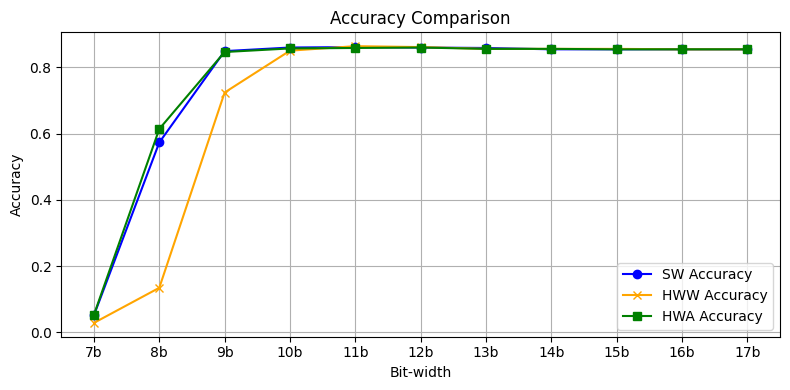

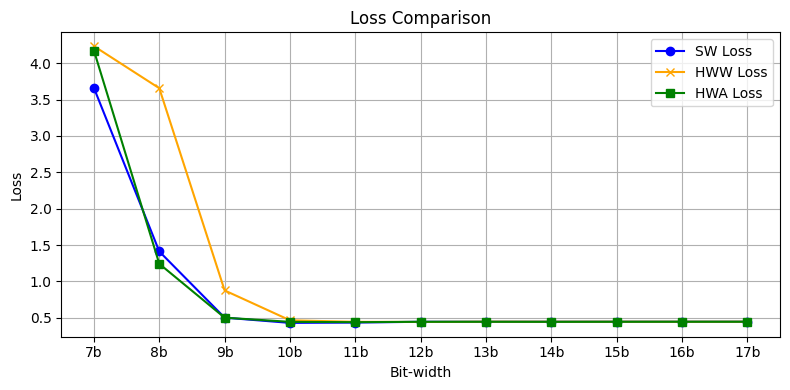

{
    "7b": {
        "accuracy": 0.05163043364882469,
        "loss": 3.6593586569247036
    },
    "8b": {
        "accuracy": 0.573369562625885,
        "loss": 1.4111525960590527
    },
    "9b": {
        "accuracy": 0.8491848111152649,
        "loss": 0.5008767159736675
    },
    "10b": {
        "accuracy": 0.8600543737411499,
        "loss": 0.42887290243221365
    },
    "11b": {
        "accuracy": 0.8614130616188049,
        "loss": 0.4334317228716353
    },
    "12b": {
        "accuracy": 0.8600543737411499,
        "loss": 0.4441825792841289
    },
    "13b": {
        "accuracy": 0.8586956262588501,
        "loss": 0.4441445026060809
    },
    "14b": {
        "accuracy": 0.854619562625885,
        "loss": 0.44474332390919974
    },
    "15b": {
        "accuracy": 0.854619562625885,
        "loss": 0.44467801373937854
    },
    "16b": {
        "accuracy": 0.854619562625885,
        "loss": 0.4444549864400988
    },
    "17b": {
        "accuracy": 0.854619562625885,

In [5]:
%%time
quant_bw_search(model, model_name, range(7,18))

---